# Tuning a Feedforward network

Building a feedforward neural network is easy.  Tuning a neural net is not so easy.  You want to avoid just trying random stuff.

In this assignment we'll create some infrastructure to make tuning more systematic, and then use it.  You'll also get exposed to some other useful things:

* how Keras models can be returned by functions
* how feedforward nets can handle large inputs, like images
* how the results of successive runs of training can give quite different results

We'll build a multi-class classifier for the famous CIFAR-10 image data set, which consists of 32 x 32 pixel color images of objects in 10 categories.



**Instructions**:

* Please start by reading the notebook carefully.
* Then provide answers to the numbered problems 1-5.
* Only modify cells as instructed.
* It may not be possible for you to restart and run all before submitting.

Hints:

* The GPU option for Colab's runtime type (see Runtime menu) is a lot faster than the default CPU.
* I created this notebook on Colab because many of you use Colab.  However, I ran out of my free allocation of resources, and ended up paying for ColabPro ($10/month, paid monthly).  You may want to do your work in Jupyter on your own machine.
* Tuning takes time.  You may want to run grid searches overnight.  Get started early enough to make this possible.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models, layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import callbacks
from sklearn.model_selection import ParameterGrid

In [ ]:
def scores_to_dataframe(scores):
    """ Return hyperparameters and scores in a data frame. """
    
    params_list, acc_list = scores
    
    params = pd.DataFrame(params_list)
    accs = pd.Series(acc_list)
    scores_df = pd.concat([params, accs], axis=1)
    
    return scores_df

### Read and preprocess the image data

**Read the data**

As mentioned, this is a famous data set, and it is a built-in Keras data set.  The images in this data set are tiny, only 32 by 32 pixels in size.  They belong to 10 classes, 0 for airplane, 1 for automobile, etc.

See [the Keras CIFAR-10 page](https://keras.io/api/datasets/cifar10/).

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


There are 50K training images and 10K test images.

The shape of the data is typical of color image data:

`X_train[image, row, col, color]`

So `X_train[0]` is the first image, `X_train[1]` is the second image, etc.

In the row position, values can range from 0-31, and the same for the col position.

In the color position, we have red/green/blue (RGB) color "channels", with a value of 0 for red, 1 for green, and 2 for blue.

The label values are 0 through 9.  They are stored in a 2D NumPy array instead of a 1D array.

In [ ]:
print(y_train[:10])

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]


**Some random images**

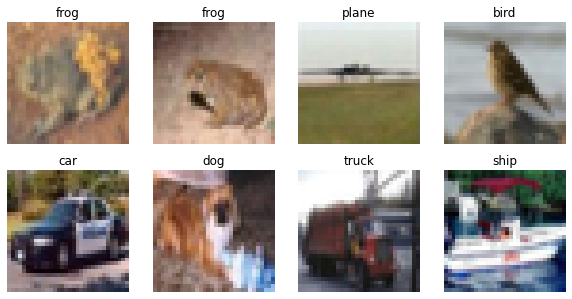

In [ ]:
idx = np.random.choice(X_train.shape[0], 8)
images = X_train[idx]
labels = y_train[idx]

fig, axs = plt.subplots(2, 4, figsize=(10,5))
for i, ax in enumerate(axs.reshape(-1)):
    ax.imshow(X_train[idx[i]])
    ax.set_title(class_names[y_train[idx[i],0]])
    ax.axis('off')

**Get a subset of the data**

We won't use the full data set because it would slow training down.

In [ ]:
np.random.seed(42)   # for repeatability
idx = np.random.choice(X_train.shape[0], 25000, replace=False)
X_train = X_train[idx]
y_train = y_train[idx]

**Flatten and scale the data**

A single input will be a long array of values.  The length of the array is 32 * 32 * 3.

In [ ]:
r, c, col = X_train.shape[1:]
X_train = X_train.reshape((-1, r * c * col))
X_train = X_train.astype("float32") / 255   # pixel values from 0 to 1
X_test  = X_test.reshape((-1, r * c * col))
X_test  = X_test.astype("float32") / 255

**Squeeze the dimensions of y_train, y_test**

The label data will be stored in 1D arrays, not 2D arrays.

In [ ]:
y_train = np.squeeze(y_train)  # this could also be done using reshape
y_test = np.squeeze(y_test)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(25000, 3072)
(25000,)
(10000, 3072)
(10000,)


In [ ]:
num_classes = np.unique(y_train).size

In [ ]:
print(num_classes)

10


## A feedforward neural network

You may know that *convolutional* neural nets are commonly used for image classification.  But we'll use a simple feedforward net here, and will be able to compare performance with a convnet later.

Create a model with 2 hidden layers plus an output layer.  There will be an output for each class.

#### **Problem 1**.  Create a Keras model for CIFAR-10 image classification with 2 hidden layers, each containing 10 neurons.  Use `num_classes` when defining the number of outputs.  Use RELU activation in the hidden layers (this added 10/14/22).  You'll need to use softmax activation in the output layer.

In [ ]:
model = models.Sequential()

# YOUR CODE HERE

The model has a lot of parameters in its first hidden layer, because each neuron in that layer has many inputs.

Some people recommend that the number of parameters in each hidden layer should be approximately the same.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30730     
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
Total params: 30,950
Trainable params: 30,950
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

**Train the model**

When evaluating accuracy, remember that our baseline is 0.1, because that is the accuracy we'd achieve by guessing, given equal number of images of each of 10 classes.

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.3)

Epoch 1/10
547/547 [==============================] - 5s 5ms/step - loss: 2.3049 - accuracy: 0.1036 - val_loss: 2.3027 - val_accuracy: 0.0976
Epoch 2/10
547/547 [==============================] - 2s 4ms/step - loss: 2.3026 - accuracy: 0.0991 - val_loss: 2.3027 - val_accuracy: 0.0976
Epoch 3/10
547/547 [==============================] - 2s 4ms/step - loss: 2.3026 - accuracy: 0.0997 - val_loss: 2.3028 - val_accuracy: 0.0976
Epoch 4/10
547/547 [==============================] - 2s 4ms/step - loss: 2.3025 - accuracy: 0.1014 - val_loss: 2.3029 - val_accuracy: 0.0976
Epoch 5/10
547/547 [==============================] - 2s 4ms/step - loss: 2.3026 - accuracy: 0.1008 - val_loss: 2.3028 - val_accuracy: 0.0976
Epoch 6/10
547/547 [==============================] - 2s 4ms/step - loss: 2.3026 - accuracy: 0.1018 - val_loss: 2.3028 - val_accuracy: 0.0976
Epoch 7/10
547/547 [==============================] - 2s 4ms/step - loss: 2.3025 - accuracy: 0.0995 - val_loss: 2.3028 - val_accuracy: 0.0976
Epoch 

**Use the model to make predictions**

Note that the output is a probability distribution over the possible target values.

In [ ]:
test_digits = X_test[0:10]
predictions = model.predict(test_digits)
predictions[0]

array([0.09903407, 0.09910464, 0.09928594, 0.10232144, 0.09699019,
       0.10158176, 0.0968587 , 0.10121251, 0.10280646, 0.10080428],
      dtype=float32)

Notice that the sum of the predictions is 1, and the predicted class can be found with argmax().

In [ ]:
print(predictions[0].sum())
print(predictions[0].argmax())

0.99999994
8


**Evaluating the model on new data**

This illustrate the model method evaluate(), which we haven't discussed in class.

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"test accuracy: {test_acc: .3f}")

313/313 [==============================] - 1s 3ms/step - loss: 2.3028 - accuracy: 0.1000
test accuracy:  0.100


**Early stopping**

Keras supports callbacks, which are basically functions that can be provided to Keras to be run during training.  You can write custom callback functions, but Keras provides a few standard ones, including one for "early stopping".

The idea of early stopping is that the training process can be stopped when a certain metric stops increasing or decreasing.  In this case, we want to stop training when validation loss stops lowering.

The validation loss can go up and down a little randomly, so we don't want to stop training as soon as validation loss does not decrease.  We might want to "be patience" and wait a few epochs to see if the value gets lower.

In [ ]:
patience=2   # wait for 2 epochs to see if validation loss will decrease
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=patience)   

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, callbacks=[early_stopping], batch_size=32, validation_split=0.3)

Epoch 1/20
547/547 [==============================] - 3s 4ms/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 2.3028 - val_accuracy: 0.0976
Epoch 2/20
547/547 [==============================] - 2s 4ms/step - loss: 2.3026 - accuracy: 0.0997 - val_loss: 2.3028 - val_accuracy: 0.0976
Epoch 3/20
547/547 [==============================] - 2s 4ms/step - loss: 2.3026 - accuracy: 0.1017 - val_loss: 2.3029 - val_accuracy: 0.0976


## Package up the model in a function

It is common to write a function to build and return a Keras model.  One reason to do this is to make it easy to create customized versions of a model.

#### **Problem 2**.  Write a function that will return a model with the given activation function and the given number of hidden layers and hidden layer sizes.  Only the first hidden layer should provide an input shape.  You can use the shape of X_train to determine the input shape.

A value of layer_sizes = [10, 5] means "2 hidden layers, with the first containing 10 neurons and the second containing 5 neurons".

Hint: your code will be simpler if you use a Keras InputLayer, as opposed to defining the input shape in the first dense layer.

In [ ]:
def get_model(act_fun="relu", layer_sizes=[10]):
    model = models.Sequential()

    # YOUR CODE HERE
    
    return model

By default, we get a model with one hidden layer of 10 neurons, and the relu activation function in the hidden layers.

In [ ]:
model = get_model()

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                30730     
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
_________________________________________________________________


An example with 10 hidden layers, and ELU activation.

In [ ]:
model = get_model(act_fun='elu', layer_sizes=[10, 5])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 10)                30730     
                                                                 
 dense_6 (Dense)             (None, 5)                 55        
                                                                 
 dense_7 (Dense)             (None, 10)                60        
                                                                 
Total params: 30,845
Trainable params: 30,845
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.3)

Epoch 1/5
547/547 [==============================] - 3s 5ms/step - loss: 2.1920 - accuracy: 0.1807 - val_loss: 2.0641 - val_accuracy: 0.2080
Epoch 2/5
547/547 [==============================] - 2s 4ms/step - loss: 2.0494 - accuracy: 0.2205 - val_loss: 2.1282 - val_accuracy: 0.2196
Epoch 3/5
547/547 [==============================] - 2s 4ms/step - loss: 1.9827 - accuracy: 0.2489 - val_loss: 1.9159 - val_accuracy: 0.2780
Epoch 4/5
547/547 [==============================] - 2s 4ms/step - loss: 1.9358 - accuracy: 0.2654 - val_loss: 1.9254 - val_accuracy: 0.2688
Epoch 5/5
547/547 [==============================] - 2s 4ms/step - loss: 1.9006 - accuracy: 0.2822 - val_loss: 2.0056 - val_accuracy: 0.2636


Here the average validation accuracy for the final two epochs is reported.

In [ ]:
mean_acc = np.mean(history.history['val_accuracy'][-2:])
print(f"averaged validation accuracy: {mean_acc: .3f}")

averaged validation accuracy:  0.266


### Grid search

Here we define the default hyperparameter values.  If we want to include more hyperparameters, this dictionary must be extended.

In [ ]:
default_params = {
    'act_fun': 'relu',
    'layer_sizes': [20, 20],
    'optimizer': 'rmsprop',
    'batch_size': 8
}

**A function to evaluate hyperparameter settings**

In searching for good hyperparameter settings, it is handy to write a function that computes how well a set of hyperparameter settings work.

This function builds a model, compiles it, trains it, and then reports on the model accuracy, using the hyperparameters in 'params'.

In [ ]:
def evaluate_params(params, verbose=1):
    """ Return validation accuracy for a model built and trained using the given parameters.
    args:
        params: a Python dictionary
    """

    # default parameters are used if not supplied
    pars = default_params.copy()
    pars.update(params)

    act_fun = pars['act_fun']
    layer_sizes = pars['layer_sizes']
    optimizer = pars['optimizer']
    batch_size = pars['batch_size']

    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=2)   

    model = get_model(act_fun=act_fun, layer_sizes=layer_sizes)
    model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
    
    history = model.fit(X_train, y_train, epochs=50, callbacks=[early_stopping], batch_size=batch_size, 
                        validation_split=0.3, verbose=verbose)
    mean_acc = np.mean(history.history['val_accuracy'][-2:])   

    return pars, mean_acc, history

**A function to perform grid search**

With our evaluate_params() function, it's easy to create a function to perform hyperparameter search.

To define the parameter combinations we want to search, we will use a dictionary like this, where the keys are hyperparameter names and the values are lists of possible hyperparameter values:

`{'act_fun': ['relu', 'elu'], 'layer_sizes': [[10], [10,5]]}`

It's also possible to use a list of such dictionaries, like this:

`[{'act_fun': ['relu'], 'layer_sizes': [[10], [20]]}, 
  {'act_fun: ['elu'], 'layer_sizes': [[20], [50]]}]`

In [ ]:
def grid_search(param_grid, verbose=1):

    params_list = []
    acc_list = []
    for params in ParameterGrid(param_grid):
        print(f"params: {params}")
        pars, acc, history = evaluate_params(params, verbose=verbose)

        params_list.append(pars)
        acc_list.append(acc)

    return params_list, acc_list

**A grid search example**

Look at the params carefully to make sure you understand how ParameterGrid() works.

In [ ]:
param_grid = {'act_fun': ['relu', 'elu'], 'layer_sizes': [[20], [10,10]]}
results = grid_search(param_grid)

params: {'act_fun': 'relu', 'layer_sizes': [20]}
Epoch 1/50
2188/2188 [==============================] - 9s 4ms/step - loss: 2.3088 - accuracy: 0.0977 - val_loss: 2.3027 - val_accuracy: 0.1005
Epoch 2/50
2188/2188 [==============================] - 8s 3ms/step - loss: 2.3028 - accuracy: 0.1019 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 3/50
2188/2188 [==============================] - 9s 4ms/step - loss: 2.3029 - accuracy: 0.0998 - val_loss: 2.3031 - val_accuracy: 0.0975
params: {'act_fun': 'relu', 'layer_sizes': [10, 10]}
Epoch 1/50
2188/2188 [==============================] - 9s 4ms/step - loss: 2.3029 - accuracy: 0.1017 - val_loss: 2.3028 - val_accuracy: 0.0975
Epoch 2/50
2188/2188 [==============================] - 11s 5ms/step - loss: 2.3027 - accuracy: 0.0983 - val_loss: 2.3031 - val_accuracy: 0.0975
Epoch 3/50
2188/2188 [==============================] - 9s 4ms/step - loss: 2.3027 - accuracy: 0.1023 - val_loss: 2.3028 - val_accuracy: 0.0999
params: {'act_fun': 'elu', 'layer

`scores_to_dataframe()` is very useful in getting a summary of the result of a grid search.

In [ ]:
scores_to_dataframe(results)

,act_fun,layer_sizes,optimizer,batch_size,0
0,relu,[20],rmsprop,8,0.098733
1,relu,"[10, 10]",rmsprop,8,0.098667
2,elu,[20],rmsprop,8,0.354267
3,elu,"[10, 10]",rmsprop,8,0.346067


### What is the variation in accuracy across multiple training runs?

If you train a model multilple times, you will get a different accuracy value each time.  This is super important in hyperparameter tuning, because you can mistake noise for an improvement due to a change in hyperparameter values.

Let's do a test by evaluating the same model multiple times.

In [ ]:
for _ in range(4):
    params_list, acc_list = grid_search({}, verbose=1)
    print(f"val. accuracy: {acc_list[0]:.3f}")

params: {}
Epoch 1/50
2188/2188 [==============================] - 10s 4ms/step - loss: 2.3049 - accuracy: 0.0997 - val_loss: 2.3029 - val_accuracy: 0.1005
Epoch 2/50
2188/2188 [==============================] - 8s 4ms/step - loss: 2.3031 - accuracy: 0.1055 - val_loss: 2.3025 - val_accuracy: 0.1008
Epoch 3/50
2188/2188 [==============================] - 9s 4ms/step - loss: 2.1487 - accuracy: 0.1656 - val_loss: 2.0721 - val_accuracy: 0.1809
Epoch 4/50
2188/2188 [==============================] - 9s 4ms/step - loss: 2.0868 - accuracy: 0.1800 - val_loss: 2.2488 - val_accuracy: 0.1465
Epoch 5/50
2188/2188 [==============================] - 9s 4ms/step - loss: 2.0703 - accuracy: 0.1791 - val_loss: 2.0594 - val_accuracy: 0.1984
Epoch 6/50
2188/2188 [==============================] - 9s 4ms/step - loss: 2.0619 - accuracy: 0.1822 - val_loss: 2.1003 - val_accuracy: 0.1868
Epoch 7/50
2188/2188 [==============================] - 9s 4ms/step - loss: 2.0587 - accuracy: 0.1871 - val_loss: 2.0305 - v

Notice that the number of training epochs is related to the reported validation accuracy.  Could it be that our patience value for early stopping is too small?

The message is that you have to be careful about the changing hyperparameter values based on a single test.

### A function to perform random search

The problem with grid search is that the number of possible hyperparameter combinations grows exponentially with the number of hyperparameters.

There's lots of active research on better ways to perform hyperparameter tuning.  A simple alternative to grid search is random search, in which you just try random hyperparameter settings and hope to get lucky.

In [ ]:
def random_search(param_grid, num_tests=5, random_state=None, verbose=1):
    """ Randomly (without replacement) evaluate parameter combinations of param_grid.
    
    args:
        param_grid  a ParameterGrid
        num_tests   maximum number of parameter combinations to try.  If there
                    are fewer than num_tests combinations in param_grid, use only
                    the number of combinations available
        random_state
    """

    if random_state is not None:
        np.random.seed(random_state)
    
    # create a list of unique parameter combinations
    param_combs = list(ParameterGrid(param_grid))
    if len(param_combs) < num_tests:
        num_tests = len(param_combs)
    random_combs = np.random.choice(param_combs, size=num_tests, replace=False)
    
    # evaluate each of the combinations
    params_list = []
    acc_list = []
    for params in random_combs:
        print(f"params: {params}")
        pars, acc, history = evaluate_params(params, verbose=verbose)

        params_list.append(pars)
        acc_list.append(acc)

    return params_list, acc_list

**A random search example**

Look at the hyperparameter settings that were randomly selected.

In [ ]:
param_grid = {'act_fun': ['relu', 'elu'], 'layer_sizes': [[20], [10,10]]}
results = random_search(param_grid, num_tests=3, random_state=0)

params: {'act_fun': 'elu', 'layer_sizes': [20]}
Epoch 1/50
2188/2188 [==============================] - 10s 4ms/step - loss: 2.0432 - accuracy: 0.2631 - val_loss: 1.8734 - val_accuracy: 0.3196
Epoch 2/50
2188/2188 [==============================] - 9s 4ms/step - loss: 1.8752 - accuracy: 0.3313 - val_loss: 1.9386 - val_accuracy: 0.3009
Epoch 3/50
2188/2188 [==============================] - 9s 4ms/step - loss: 1.8007 - accuracy: 0.3610 - val_loss: 2.0605 - val_accuracy: 0.2979
params: {'act_fun': 'elu', 'layer_sizes': [10, 10]}
Epoch 1/50
2188/2188 [==============================] - 10s 4ms/step - loss: 2.0902 - accuracy: 0.2373 - val_loss: 1.9649 - val_accuracy: 0.2845
Epoch 2/50
2188/2188 [==============================] - 10s 4ms/step - loss: 1.9304 - accuracy: 0.3054 - val_loss: 1.8588 - val_accuracy: 0.3284
Epoch 3/50
2188/2188 [==============================] - 9s 4ms/step - loss: 1.8583 - accuracy: 0.3315 - val_loss: 1.9025 - val_accuracy: 0.3167
Epoch 4/50
2188/2188 [===========

### Batch normalization 

The most commonly-recommended way to apply batch normalization is between the summation part of a neuron and the activation function.  See Listings 9.4 and 9.5 in the Chollet text.

Also, in a feedforward network, you would apply batch normalization in one or more hidden layers, not the output layer.

#### **Problem 3**.  Make modifications to support batch normalization in the hidden layers of your model.  The new hyperparameter should be named 'batch_norm' and should take value True or False.  Use False as the default.

In [ ]:
# update get_model
def get_model(act_fun="relu", layer_sizes=[10], batch_norm=False):
    model = models.Sequential()

    # YOUR CODE HERE      
    
    return model

In [ ]:
# update default_params
default_params = {
    'act_fun': 'relu',
    'layer_sizes': [20, 20],
    'optimizer': 'rmsprop',
    'batch_size': 8

    # YOUR CODE HERE
}

In [ ]:
# update evaluate_params
def evaluate_params(params, verbose=1):
    """ Return validation accuracy for a model built and trained using the given parameters.
    args:
        params: a Python dictionary
    """

    # default parameters are used if not supplied
    pars = default_params.copy()
    pars.update(params)

    act_fun = pars['act_fun']
    layer_sizes = pars['layer_sizes']
    optimizer = pars['optimizer']
    batch_size = pars['batch_size']

    # YOUR CODE HERE

    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=2)   

    model = get_model(act_fun=act_fun, layer_sizes=layer_sizes, batch_norm=batch_norm)
    model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
    
    history = model.fit(X_train, y_train, epochs=50, callbacks=[early_stopping], batch_size=batch_size, 
                        validation_split=0.3, verbose=verbose)
    mean_acc = np.mean(history.history['val_accuracy'][-2:])   

    return pars, mean_acc, history

**Test batch normalization**

In [ ]:
param_grid = {'batch_norm': [True, False]}
results = grid_search(param_grid)

params: {'batch_norm': True}
Epoch 1/50
2188/2188 [==============================] - 13s 6ms/step - loss: 1.9791 - accuracy: 0.2878 - val_loss: 2.1722 - val_accuracy: 0.2693
Epoch 2/50
2188/2188 [==============================] - 11s 5ms/step - loss: 1.8539 - accuracy: 0.3427 - val_loss: 1.8548 - val_accuracy: 0.3347
Epoch 3/50
2188/2188 [==============================] - 11s 5ms/step - loss: 1.8150 - accuracy: 0.3558 - val_loss: 1.7408 - val_accuracy: 0.3765
Epoch 4/50
2188/2188 [==============================] - 11s 5ms/step - loss: 1.7766 - accuracy: 0.3713 - val_loss: 1.8331 - val_accuracy: 0.3607
Epoch 5/50
2188/2188 [==============================] - 11s 5ms/step - loss: 1.7626 - accuracy: 0.3726 - val_loss: 1.7715 - val_accuracy: 0.3693
params: {'batch_norm': False}
Epoch 1/50
2188/2188 [==============================] - 10s 4ms/step - loss: 2.2105 - accuracy: 0.1544 - val_loss: 2.1522 - val_accuracy: 0.1617
Epoch 2/50
2188/2188 [==============================] - 9s 4ms/step - l

#### **Problem 4**.  Try to tune the model to get a high validation accuracy value.

Use grid search and/or random search.

Don't add additional hyperparameters, but feel free to add additional possible values for existing hyperparameters.

Do not modify the code above, but you can redefine existing code as in the last problem.

You will probably want to report on your testing with one or more tables showing hyperparameter values and accuracies.  See the scores_to_dataframe() example above.

In [ ]:
# YOUR CODE HERE

# Feel free to add additional code and markdown cells


Write your summary here.

Write a summary of your findings for this problem.

#### **Problem 5**.  Add an additional hyperparameter, and continue tuning.

For example, you could add a new hyperparameter related to optimizer learning rate.

Your goal is to achieve a high validation accuracy value.

Note that a hyperparameter could be used in either get_model() or in evaluate_params().

In [ ]:
# YOUR CODE HERE

# Feel free to add additional code and markdown cells


Write your summary here.

Write a summary of your findings for this problem.